In [3]:
import os
wd = os.getcwd()
wd = os.path.dirname(wd)
import sys
sys.path.append(wd+"\\src\\")

In [4]:
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
import numpy.random as rnd
from powderlayer import PowderBD, PowderOvLayer, Powder
from gaslayer import GasEOS, GasLayer
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [5]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets
mpl.rcParams['figure.figsize'] = (5,3) 

import json
from functional import seq

In [7]:
from opti.Chromosome import DRange, SRange,ChromoController
# from conegene import ConeGene
import numpy.random as rnd
from copy import deepcopy
from scipy.special import softmax
import pickle

In [89]:
sandwich_dict = {'tube': {'tube_points': [
    (0, 0.023),
    (1, 0.023)]},
 'x_left': 0,
 'layers': [{'type': 'gas',
   'name': 'Some',
   'gamma': 1.4,
   'kappa': 0.0,
   'R': 283,
   'T_0': 283,
   'W_0' :0.023**2/4*np.pi,
   'p_0': 1,
   'u_0': 0}],
 'borders': [{'mass': 1000,
   'p_f': 100000000000.0,
   't_init': -1,
   'w_border': 0.0},
  {'mass': 1000,
   'p_f': 100000000000,
   't_init': -1,
   'w_border': 0}],
 'calc_settings': {'powder_settings': {'cell_dx': 0.0025,
   'n_cells_min': 13,
   'n_cells_max': 2000,
   'GasFluxCalculator_kwargs': {'flux_type': 2},
   'GridStrecher_kwargs': {}},
  'gas_settings': {'cell_dx': 0.0025,
   'n_cells_min': 13,
   'n_cells_max': 200,
   'GasFluxCalculator_kwargs': {'flux_type': 1},
   'GridStrecher_kwargs': {}},
  'pist_settings': {'cell_dx': 0.0025,
   'n_cells_min': 13,
   'n_cells_max': 2000,
   'GasFluxCalculator_kwargs': {'flux_type': 1},
   'GridStrecher_kwargs': {}}}}

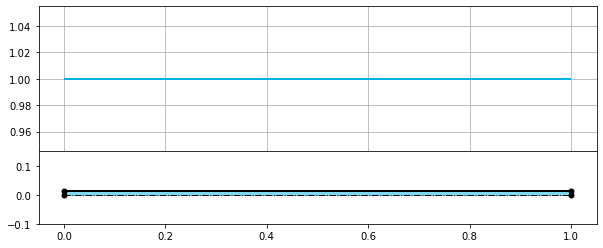

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=1e-06 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':1.0, 'tau_min': 1.4932053970468174e-05, 
        'u_max': 0.0, 'cs_max': 334.85011572343825, 'dx_min': 0.004999999999999893, 
        'x_1': 0.0, 'x_2': 1.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [90]:
from tube import InterpXY,Tube,BorderSimple
import numpy as np
from gaslayer import GasEOS, GasLayer
from powderlayer import PowderOvLayer
from pistonlayer import ElPistLayer

class Sandwich(object):
    @classmethod
    def get_standart(cls, sandwich_dict):
        tube = Tube.get_standart(sandwich_dict['tube'])
        res = cls(tube)
        x_left = sandwich_dict.get('x_left', 0)
        b = BorderSimple.get_standart(sandwich_dict['borders'][0])
        res.borders.append(b)
        for lr_dict, b_right_dict in zip(sandwich_dict['layers'], sandwich_dict['borders'][1:]):
            if lr_dict['type'] == 'gas':
                lr = GasLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['gas_settings'])
            elif lr_dict['type'] == 'powder':
                lr = PowderOvLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['powder_settings'])
            elif lr_dict['type'] == 'pist':
                lr = ElPistLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['pist_settings'])
            else:
                t = lr_dict["type"]
                raise AttributeError(f'Неправильный тип области {t}')
            b = BorderSimple.get_standart(b_right_dict)
            res.layers.append(lr)
            res.borders.append(b)
            x_left = lr.xs_borders[-1] + b.w_border
        res.connect_borders_layers()
        return res

    def __init__(self, tube: Tube, i=0):
        self.tube = tube
        self.i = i
        self.layers = []
        self.borders= []

    def connect_borders_layers(self):
        if len(self.layers)+1 != len(self.borders):
            raise AttributeError(f'Неправильное количество границ и слоев len(self.layers)={len(self.layers)}  len(self.borders)={len(self.borders)}')
        all_layers = [None] + self.layers + [None]
        for b, lr_left, lr_right in zip(self.borders, all_layers[:-1], all_layers[1:]):
            b.lr_left = lr_left
            b.lr_right = lr_right

    def simple_step(self, courant):
        tau = min([lr.get_tau_min() for lr in self.layers]) * courant
        for b in self.borders:
            b.update_xs()
        for b in self.borders:
            b.update_Vs(tau)
        result = Sandwich(self.tube, self.i+1)
        result.layers = [lr.step_up(tau) for lr in self.layers]
        result.borders= [b.copy() for b in self.borders]
        result.connect_borders_layers()
        return result

    def plot(self, fig, ax, **kwargs):
        self.tube.plot(fig, ax, **kwargs)
        for lr in self.layers:
            lr.plot(fig, ax, **kwargs)
        for b in self.borders:
            b.plot(fig, ax, **kwargs)

    def plot_param(self, fig, ax, param_name, **kwargs):
        for lr in self.layers:
            xs = np.array(lr.xs_cells)
            ys = np.array(getattr(lr, param_name))
            color = lr.color_4_plot
            lw = kwargs.get('lw', 2)
            ax.plot(xs, ys, color=color, lw=lw)

    def get_t(self):
        ts = [lr.time for lr in self.layers]
        if abs(min(ts) - max(ts)) > 1e-14:
            print(f'Слои не синхронизированны {ts}')
        return ts[0]

    def get_vel(self):
        return self.layers[-1].Vs_borders[-1]

    def get_x_projectile(self):
        return self.layers[-1].xs_borders[-1]


    def get_p_max(self):
        p_max = -1
        for lr in self.layers:
            p = np.asarray(lr.ps)
            p_sum = np.max(p[5:] + p[4:-1] + p[3:-2] + p[2:-3] + p[1:-4] + p[:-5]) / 6
            if p_sum > p_max:
                p_max = p_sum
        return p_max

    def __str__(self):
        res = f'Sandwich i={self.i}; t={self.get_t()*1000} ms;  vel={self.get_vel()} m/s;  p_max={self.get_p_max()*1e-6} MPa\nlayers:\n'
        for i, lr in enumerate(self.layers):
            res += f'{i}) {lr}\n'
        return res

    def __repr__(self):
        return str(self)



sandw0 = Sandwich.get_standart(sandwich_dict)


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw0.plot_param(fig, ax1, 'ps')
sandw0.plot(fig, ax2)
ax2.set_ylim(-0.1,0.15)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw0

In [91]:
# sandw0.layers[0].ps[:150] = 1
# sandw0.layers[0].ps[150:] = 0.1
# sandw0.layers[0].ros[:150] = 1
# sandw0.layers[0].ros[150:] =0.125
# sandw0.layers[0].es = 1/(1.4-1)* np.asarray(sandw0.layers[0].ps)/np.asarray(sandw0.layers[0].ros)
def ropu(x, *args):
    return (1,1,0) if x < 0.5 else (0.125, 0.1, 0)
sandw0.layers[0].init_ropue_fromfoo(ropu)

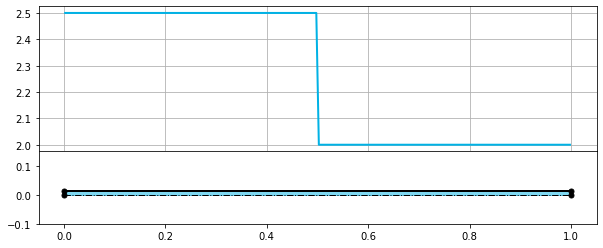

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=1e-06 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':1.0, 'tau_min': 0.00422577127364254, 
        'u_max': 0.0, 'cs_max': 1.1832159566199232, 'dx_min': 0.004999999999999893, 
        'x_1': 0.0, 'x_2': 1.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [92]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw0.plot_param(fig, ax1, 'es')
sandw0.plot(fig, ax2)
ax2.set_ylim(-0.1,0.15)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw0

In [95]:
sandws = [sandw0]
for i in range(200):
    sandw = sandws[-1].simple_step(0.49)
    sandws.append(sandw)


In [96]:
collect = sandws
@interact(ind=ipywidgets.IntSlider(min=0,max=len(collect)-1,step=1, value=0))
def fooz(ind):
    sandw = sandws[ind]
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
    sandw.plot_param(fig, ax1, 'ps')
    sandw.plot(fig, ax2)
    ax2.set_ylim(-0.1,0.15)
    ax1.grid(True)
    plt.subplots_adjust(hspace=.0)

    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=200), Output()), _dom_classes=('widget-interac…

In [97]:
sys.path.append(wd+"\\src\\include\\godunov")
from riman_python import get_distrs_to_time

In [98]:
def get_init_conds_4_tsts():
    # из статьи ОДНОМЕРНЫЕ ЗАДАЧИ ГАЗОВОЙ ДИНАМИКИ И ИХ РЕШЕНИЕ  ПРИ ПОМОЩИ РАЗНОСТНЫХ СХЕМ ВЫСОКОЙ  РАЗРЕШАЮЩЕЙ СПОСОБНОСТИ 
    #           LEFT          RIGHT              
    #      ro       u       p       ro      u       p       t
    v = [
         ( 1,       0,      1,      0.125,  0,      0.1,    0.2 ),
         ( 0.445,   0.698,  3.528,  0.5,    0,      0.571,  0.15  ),       
         ( 1,       0,      1,      0.02,   3.55,   1,      0.15  ),
         ( 3.857,   0.920,  10.333, 1,      3.55,   1,      0.09  ),
         ( 1,       0,      0.5,    0.5,    0,      0.5,    0.42  ),
         ( 1,       0.5,    0.5,    0.5,    0.5,    0.5,    0.43  ),
         ( 1,       -1,     1,      0.9275, -1.0781,0.9,    0.18  ),
         ( 1,       0,      1000,   1,      0,      0.01,   0.012  ),
         ( 10,      2000,   500,    20,     0,      500,    0.012  ),
         ( 1,       -2,     0.4,    1,      2,      0.4,    0.15  )
        ]
    for ro_1, u_1, p_1, ro_2, u_2, p_2, t in v:
        yield {
            'p_1' : p_1,          # давление слева
            'ro_1' : ro_1,         # плотность слева   
            'u_1' : u_1,          # скорость слева      
            'p_2' : p_2,        # давление справа     
            'ro_2': ro_2,      # плотность справа    
            'u_2' : u_2,          # скорость справа        
            'p_0' : 0,          # параметр в ур-ии состояния        
            'gamma' : 1.4,      # параметр в ур-ии состояния          
            'c_0' : 0,          # параметр в ур-ии состояния     
            'eps_F':1e-12,       # точность определения решения           
            'n_iter_max':300,   # максимальное количество итераций при определении решения              
            'x0' : 0.5,         # положение разрыва в момент t=0        
            'ts': [t],        # времена, в которых нужно построить графики распределения параметров         
            'n': 3000,         # кол-во точек, в которых ищутся параметры волны разрежения         
           # 'save_to': r'sod.txt'
        } 

In [99]:
init_cond = [d for d in get_init_conds_4_tsts()][0]
init_cond

{'p_1': 1,
 'ro_1': 1,
 'u_1': 0,
 'p_2': 0.1,
 'ro_2': 0.125,
 'u_2': 0,
 'p_0': 0,
 'gamma': 1.4,
 'c_0': 0,
 'eps_F': 1e-12,
 'n_iter_max': 300,
 'x0': 0.5,
 'ts': [0.2],
 'n': 3000}

In [100]:
res = get_distrs_to_time(0.15, **init_cond)
res

{'xs': array([0.00000000e+00, 3.33444481e-04, 6.66888963e-04, ...,
        9.99333111e-01, 9.99666556e-01, 1.00000000e+00]),
 'ros': array([1.   , 1.   , 1.   , ..., 0.125, 0.125, 0.125]),
 'ps': array([1. , 1. , 1. , ..., 0.1, 0.1, 0.1]),
 'us': array([0., 0., 0., ..., 0., 0., 0.]),
 'es': array([2.5, 2.5, 2.5, ..., 2. , 2. , 2. ]),
 'ms': array([0., 0., 0., ..., 0., 0., 0.])}

In [101]:
results = []
for sandw in sandws:
    res = {
        'time': sandw.layers[0].time,
        'ps': np.array(sandw.layers[0].ps),
        'es': np.array(sandw.layers[0].es),
        'ros': np.array(sandw.layers[0].ros),
        'us': np.array(sandw.layers[0].us),
        'xs': np.array(sandw.layers[0].xs_cells)
    }
    if res['time'] > 0:
        res['ideal'] = get_distrs_to_time(sandw.layers[0].time, **init_cond)
    results.append(res)

In [102]:
collect = results
@interact(ind=ipywidgets.IntSlider(min=1,max=len(collect)-1,step=1, value=1))
def fooz(ind):
    res = collect[ind]
    col='red'
    col2 = 'blue'
    lw = 2
    t = res['time']
    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))#, gridspec_kw={'height_ratios':[1, 1, 1]})
    ax1.plot(res['xs'], res['ros'], c=col, lw=lw, label=f't = {t}', alpha=0.7)
    ax1.plot(res['ideal']['xs'], res['ideal']['ros'], c=col2, lw=lw, label=f't = {t}', alpha=0.7)
    ax1.grid(True)
#     ax1.legend()
    ax1.set_ylabel(r'$\rho$')
    
    ax2.plot(res['xs'], res['ps'], c=col, lw=lw, label=f't = {t}')
    ax2.plot(res['ideal']['xs'], res['ideal']['ps'], c=col2, lw=lw, label=f't = {t}')
    ax2.grid(True)
#     ax2.legend()
    ax2.set_ylabel(r'$p$')
    
    ax3.plot(res['xs'], res['us'], c=col, lw=lw, label=f't = {t}', alpha=0.7)
    ax3.plot(res['ideal']['xs'], res['ideal']['us'], c=col2, lw=lw, label=f't = {t}', alpha=0.7)
    ax3.grid(True)
#     ax3.legend()
    ax3.set_xlabel(r'$x$')
    
    ax4.plot(res['xs'], res['es'], c=col, lw=lw, label=f't = {t}')
    ax4.plot(res['ideal']['xs'], res['ideal']['es'], c=col2, lw=lw, label=f't = {t}', alpha=0.7)
    ax4.grid(True)
#     ax4.legend()
    ax4.set_ylabel(r'$e$')
    ax4.set_xlabel(r'$x$')
    plt.show()

interactive(children=(IntSlider(value=1, description='ind', max=200, min=1), Output()), _dom_classes=('widget-…

In [103]:
with open('sod.bin', 'wb') as f:
    pickle.dump(results, f)